# Rozdzielczość obrazu. Interpolacja.

## Cel zajęć:

* zapoznanie z pojęciem rozdzielczości przestrzennej (rozmiaru obrazu),
* metody interpolacji najbliższego sąsiada oraz dwuliniowa,
* zapoznanie z pojęciem rozdzielczości dpi (ang. dots per inch),
* zapoznanie z pojęciem rozdzielczości  poziomów jasności (dla obrazów w skali szarości),
* zadanie domowe: interpolacja dwusześcienna.

## Rodzielczość przestrzenna

Dyskretna reprezentacja obrazu to zwykle macierz dwu (N x M - obraz w skali szarości) lub trójwymiarowa (N x M x 3 - obraz kolorowy).
Przez rozdzielczość przestrzenną rozumie się liczbę pikseli z których składa się obraz.
Przykładowo rozdzielczość VGA to  640 x 480, Full HD to 1920 x 1080, a 4K to 3840 x 2160.
Rozdzielczość obrazu można modyfikować (zwiększać/zmniejszać), co nazywa się skalowaniem obrazu.
Warto wiedzieć, że zwiększenie rozdzielczości obrazu nie zwiększa ilości informacji, a jedynie liczbę pikseli (w sensie "lepiej nie będzie").
Ponadto skalowanie zawsze wprowadza pewne zniekształcenia, nawet przy zmniejszaniu rozmiaru.

W ramach niniejszego ćwiczenia zapoznamy się z metodami interpolacji, które są podstawą takich operacji jak: przybliżanie (zoom), zmiana rozdzielczości, rotacja obrazu, czy też korekcje geometryczne.
Jako przykład posłuży nam zmiana rozdzielczości, czyli inaczej mówiąc przepróbkowanie obrazu.
Dla przypomnienia - interpolacja to wykorzystanie znanych danych (wartości dla tzw. punktów węzłowych) do określania wartości w nieznanych lokalizacjach.

Zacznijmy od prostego przykładu.
Mamy obraz o rozdzielczości 500 x 500 pikseli, a chcemy go powiększyć do 750 x 750 pikseli -- tj. o~współczynnik 1,5.
Wyobraźmy sobie zatem, że dysponujemy siatką 750 x 750 o takim samym "rozmiarze" pojedynczego piksela jak obraz oryginalny.
Następnie siatkę tą ,,ścieśniamy'', tak aby miała rozmiar 500 x 500.
W rezultacie otrzymana siatka będzie miała mniejszy rozmiar pojedynczego piksela niż obraz oryginalny.
Schematycznie przedstawiono to na poniższym rysunku.

![Ilustracja interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interEx57.png)


Pokazuje on przykład interpolacji: a) obraz 5x5, b) oraz 7x7, c) obraz 7x7 zmiejszony do 5x5.


Chcemy teraz poszczególnym elementom nowej siatki przyporządkować piksele z obrazu wejściowego.
Jedną z możliwości jest poszukanie "najbliższego" piksela w oryginalnym obrazie i wzięcie jego wartości.
Przykład takiego postępowania zaprezentowano na  poniższym rysunku.

![Ilustracja najbliższego sąsiada](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/inteNNEx.png)

Kilka słów wyjasnienia.
Kolorem ciemnoszarym oznaczono siatkę 5x5, a czarnym 7x7 (już po przeskalowaniu).
Nasze zadanie sprowadza się do zalezienia dla każdej kropki czarnej (umowny środek piksela), najbliżej leżącej kropki szarej - oznaczono to dla pierwszych trzech wierzszy obrazu liniami.

Po zrealizowaniu powyższego kroku dla całego obrazu wykonujemy "rozciągniecie" do rozdzielczości 750 x 750.
W ten sposób uzyskujemy finalny efekt zmiany rozdzielczości.

## Interpolacja metodą najbliższego sąsiada

Takie postępowanie określa się mianem **interpolacji metodą najbliższego sąsiada** (ang. *nearest neighbour interpolation*).
W ramach pierwszego etapu ćwiczenia zaimplementujemy to podejście.

1. Ładujemy potrzebne biblioteki, pobieramy obrazy z repozytorium, wczytujemy jeden z obrazów testowych (*parrot.bmp*) i wyświetlamy go:

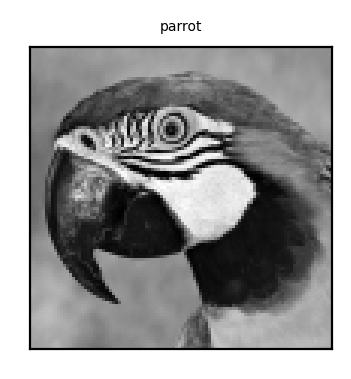

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

# Load required files
if not os.path.exists("parrot.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/parrot.bmp --no-check-certificate
if not os.path.exists("clock.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/clock.bmp --no-check-certificate
if not os.path.exists("chessboard.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/chessboard.bmp --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/lena.bmp --no-check-certificate
if not os.path.exists("firetruck.jpg") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/firetruck.jpg --no-check-certificate


parrot = cv2.imread('parrot.bmp')           # Read image
parrot = cv2.cvtColor(parrot, cv2.COLOR_BGR2GRAY) # Convert to RGB

clock = cv2.imread('clock.bmp')       
clock = cv2.cvtColor(clock, cv2.COLOR_BGR2GRAY) 

chessboard = cv2.imread('chessboard.bmp')       
chessboard = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)

lena = cv2.imread('lena.bmp')       
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)

firetruck = cv2.imread('firetruck.jpg')       
firetruck = cv2.cvtColor(firetruck, cv2.COLOR_BGR2GRAY)

# Display
def display_I(I, title):
    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(I, cmap ="gray")
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.title(title, fontsize = 5)
    plt.show()
    
display_I(parrot, "parrot")

2. Definiujemy funkcję do interpolacji metodą najbliższego sąsiada.

Jako argumenty wejściowe powinna ona przyjąć obraz oraz współczynniki skalowania w pionie i poziomie.
Wyjściem powinien być natomiast obraz w nowej rozdzielczości.
Wewnątrz należy:

* odczytać wymiary obrazka wejściowego,
* wyliczyć wymiary obrazka wyjściowego (tj. wymnożyć wymiary wejściowe przez skalę i zaokrąglić do liczb całkowitych),
* utworzyć nowy obraz o ww. rozmiarze,
* w pętli po nowym obrazie, dla każdego piksela, wykorzystując współczynniki skalowania, odnaleźć najbliższego sąsiada.




In [2]:
def nn_interpolation(I, x_scale, y_scale):
    h, w = I.shape
    new_h = int(h * y_scale)
    new_w = int(w * x_scale)    
    new_I = np.zeros((new_h, new_w))
        
    for iy, ix in np.ndindex(new_I.shape):
        x = round(ix / x_scale)
        y = round(iy / y_scale)
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        if x >= w:
            x = w - 1
        if y >= h:
            y = h - 1
            
        new_I[iy,ix] = I[y,x]
    return new_I

3. Testujemy stworzoną funkcję:
    * dla skali 1.5, 1.5 i obrazka *parrot*,
    * dla 2.5, 2.5 - tu okaże się, że do kodu trzeba dopisać zabezpieczenie przed wyjściem poza zakres,
    * dla niejednakowych skal np. 1.5 i 2.5,
    * dla skal mniejszych od 1,
    * dla niesymetrycznego obrazka *clock*,
    * dla obrazka z szachownicą *chessboard*.

Uwaga: proszę dla powyższych przypadków przygotować osobne sekcje kodu - tak, aby wyświetlały się wszystkie rozważane przypadki.

Wykonana metoda jest bardzo prosta i szybka, ale wprowadza pewne niepożądane artefakty, w szczególnie źle odwzorowane są linie proste.
Z drugiej strony sprawdza się w pewnych nietypowych przypadkach.
Zostanie to zademonstrowane w dalszej części ćwiczenia.

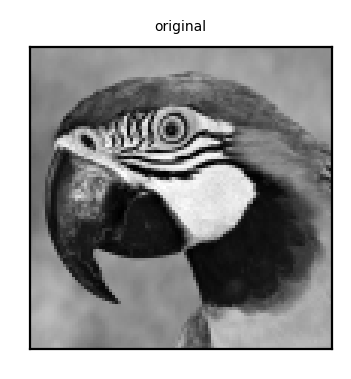

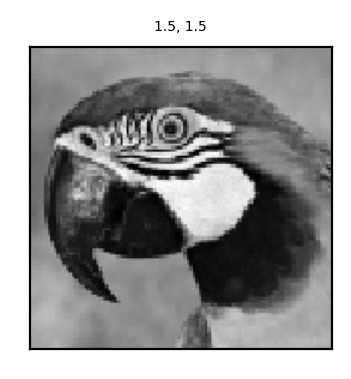

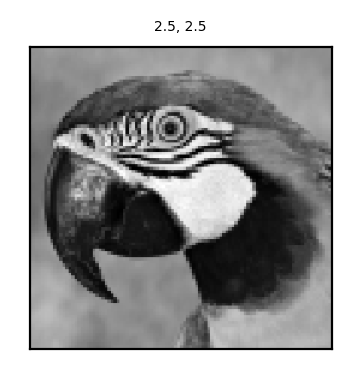

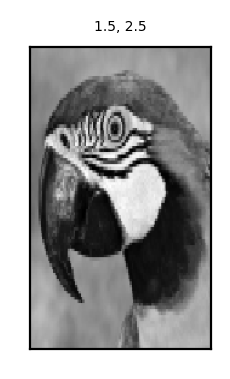

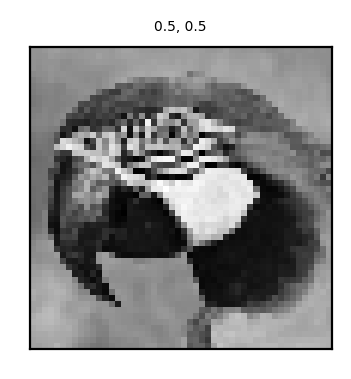

In [3]:
display_I(parrot, "original")
display_I(nn_interpolation(parrot,1.5,1.5), "1.5, 1.5")
display_I(nn_interpolation(parrot,2.5,2.5), "2.5, 2.5")
display_I(nn_interpolation(parrot,1.5,2.5), "1.5, 2.5")
display_I(nn_interpolation(parrot,0.5,0.5), "0.5, 0.5")

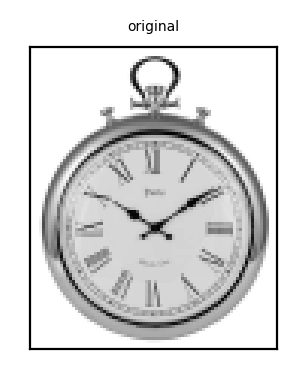

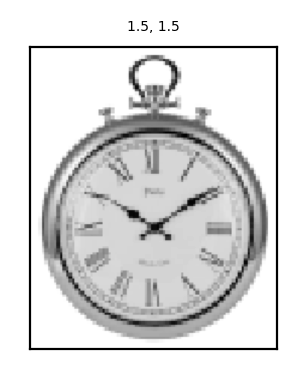

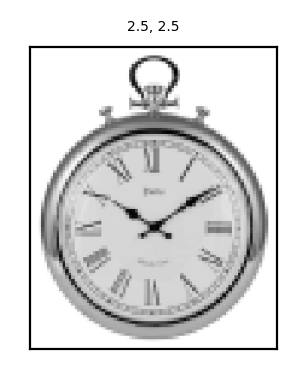

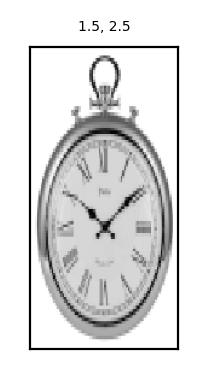

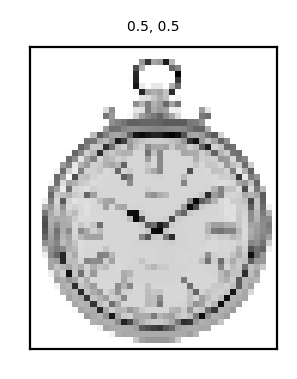

In [4]:
display_I(clock, "original")
display_I(nn_interpolation(clock,1.5,1.5), "1.5, 1.5")
display_I(nn_interpolation(clock,2.5,2.5), "2.5, 2.5")
display_I(nn_interpolation(clock,1.5,2.5), "1.5, 2.5")
display_I(nn_interpolation(clock,0.5,0.5), "0.5, 0.5")

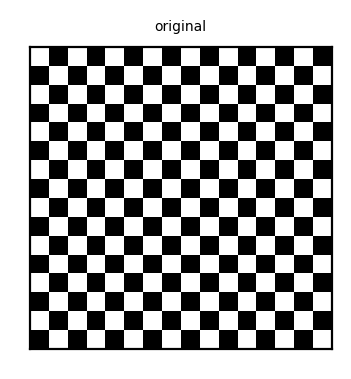

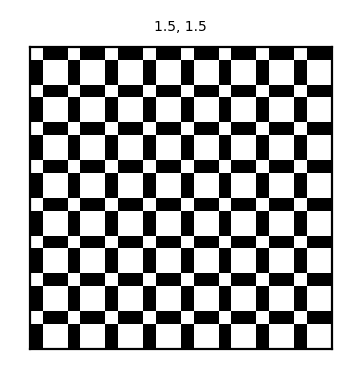

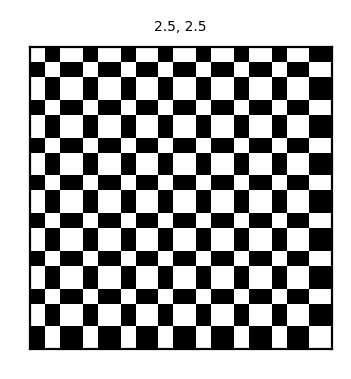

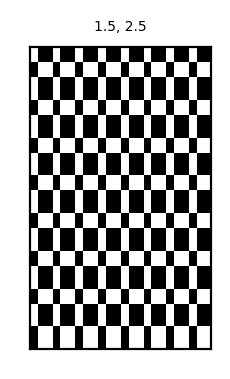

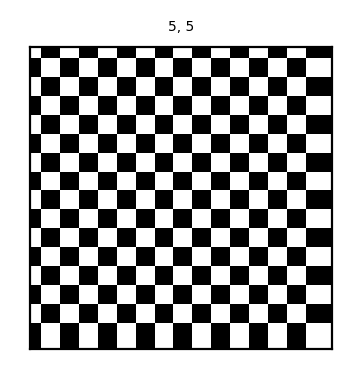

In [5]:
display_I(chessboard, "original")
display_I(nn_interpolation(chessboard,1.5,1.5), "1.5, 1.5")
display_I(nn_interpolation(chessboard,2.5,2.5), "2.5, 2.5")
display_I(nn_interpolation(chessboard,1.5,2.5), "1.5, 2.5")
display_I(nn_interpolation(chessboard,5,5), "5, 5")

## Interpolacja dwuliniowa

W praktyce, lepszym rozwiązaniem zwykle okazuje tzw. **interpolacja dwuliniowa** (ang. *bilinear interpolation*).
Wykorzystuje ona informację o czterech najbliższych sąsiadach do określenia nowej wartości piksela.

Jeśli przez $(i,j)$ oznaczymy współrzędne poszukiwanego piksela, a przez $I(i,j)$ jego jasność (składową w~odcieniach szarości) to jego wartość można obliczyć wykorzystując równanie:
\begin{equation}
I(i,j) = a \cdot i + b \cdot j+ c \cdot i \cdot j + d
\end{equation}
gdzie: współczynniki $a,b,c,d$ można wyliczyć na podstawie czterech najbliższych sąsiadów.

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

Prześledźmy to na przykładzie z powyższego rysunku.
Niech współrzędne poszczególnych punktów to $A = (j_1,i_1)$, $B = (j_1,i_2)$, $ C= (j_2,i_2)$ oraz $D = (j_2,i_1)$.
W pierwszej kolejności dokonujemy interpolacji wartości w punktach $AB$ i $CD$ -- czyli poziomo.
Wychodząc od równania prostej otrzymujemy:

\begin{equation}
f(AB) \approx \frac{i_2 - i}{i_2-i_1}f(A) + \frac{i - i_1}{i_2-i_1}f(B)
\end{equation}

\begin{equation}
f(CD) \approx \frac{i_2 - i}{i_2-i_1}f(D) + \frac{i - i_1}{i_2-i_1}f(C)
\end{equation}

Następnie wykonujemy analogiczną interpolację w pionie:
\begin{equation}
f(ABCD) \approx \frac{j_2 - j}{j_2-j_1}f(AB) + \frac{j - j_1}{j_2-j_1}f(CD)
\end{equation}

Łącząc powyższe równania otrzymujemy:
\begin{equation}
f(ABCD) \approx \frac{1}{(i_2 - i_1)(j_2-j_1)} ( f(A)(i_2-i)(j_2 - y) + f(B)(i-i_1)(j_2 - j) \\ + f(C)(i-i_1)(j-j_1) + f(D)(i_2-i)(j-j_1))
\end{equation}
gdzie zapis $f(X)$ oznacza wartość piksela w punkcie $X$.

Rozważania można uprościć przyjmując, że narożniki rozpatrywanego kwadratu mają następujące współrzędne: $A = (0,0)$, $B = (0,1)$, $ C= (1,1)$ oraz $D = (1,0)$.
Wtedy powyższe równanie można zapisać:
\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

lub macierzowo:
\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C)  \end{bmatrix}   \begin{bmatrix} 1-j \\\\ j  \end{bmatrix}
\end{equation}

Uwaga.
Nieco wbrew nazwie interpolacja dwuliniowa nie jest operacją liniową.
W złożeniu dwóch operacji liniowych pojawia się człon $xy$.

Warto dodać, że kolejny ``poziom wtajemniczenia'' to **interpolacja dwusześcienna** (ang. *bicubic interpolation*).
Dana jest ona wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}
Jej implementacja stanowi zadanie domowe do bieżącego ćwiczenia.

Trzy powyżej przedstawione metody bynajmniej nie wyczerpują tematu.
Wystarczy choćby otworzyć stronę [wiki o skalowaniu](https://en.wikipedia.org/wiki/Image_scaling), by zobaczyć, że metod jest dużo więcej.



Wykorzystując powyższe równania zaimplementuj interpolację dwuliniową:
* dobrym punktem wyjścia będzie stworzona funkcja do interpolacji metodą najbliższego sąsiada,
* początek powinien być identyczny,
* różnice rozpoczynają się w momencie obliczenia współrzędnych nowego piksela,
* jeśli chcemy zastosować opisane powyżej wzory (w wariancie uproszczonym), to musimy wyliczyć współrzędne punktów $A,B,C,D$,
* w pierwszym kroku obliczamy współrzędne $A$ tj. $(0,0)$ - należy do tego wykorzystać funkcję *floor* (np. $i_1 = floor(i / h_{scale})$).
  Proszę ten krok odnieść do przedstawionego rysunku poglądowego,
* obliczenie współrzędnych $B,C,D$ jest już proste i sprowadza się do operacji `+1`,
* potrzebujemy jeszcze część ułamkową współrzędnych punktu $ABCD$ tj. $(i,j)$ - od ilorazu $i/h_{scale}$ należy odjąć wartość $i_1$
* wykorzystując wyznaczone współrzędne, należy pobrać wartości jasności w punktach $A,B,C,D$, tj. $f(A),f(B),f(C),f(D)$, podstawić do odpowiedniego równania i wykonać interpolację.

  Uwagi:
* Tworzenie macierzy *np.array*, mnożenie macierzy *np.dot*. Przy tworzeniu macierzy proszę zwrócić uwagę na niezbędne nawiasy kwadratowe.
* Przy próbie uruchomienia kodu pewnie okaże się, że wystąpi przekroczenie zakresu - należy dodać stosowne zabezpiczenie.

Proszę dla interpolacji dwuliniowej wykonać takie same eksperymenty, jak dla  najbliższego sąsiada.




In [6]:
import math

In [7]:
def check_range(x, y, w, h):
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if x >= w:
        x = w -1
    if y >= h:
        y = h - 1
    return y, x

In [8]:
# version 1

def bilinear_interpolation(I, x_scale, y_scale):
    h, w = I.shape
    new_h = int(h * y_scale)
    new_w = int(w * x_scale)    
    new_I = np.zeros((new_h, new_w))
        
    for iy, ix in np.ndindex(new_I.shape):
        i = ix / x_scale
        j = iy / y_scale
        i1 = math.floor(i)
        j1 = math.floor(j)
        i2 = i1 + 1
        j2 = j1 + 1
        A = check_range(i1, j1, w, h)
        B = check_range(i2, j1, w, h)
        C = check_range(i2, j2, w, h)
        D = check_range(i1, j2, w, h)
        
        f_A = I[A]
        f_B = I[B]
        f_C = I[C]
        f_D = I[D]
        
        i -= i1
        j -= j1

        f_ABCD = f_A*(1 - i)*(1 - j) + f_B*i*(1 - j) + f_C*i*j + f_D*(1 - i)*j
        new_I[iy,ix] = f_ABCD
        
    return new_I

In [9]:
# version 2 (with matrix multiplication)

def bilinear_interpolation_matrix_v(I, x_scale, y_scale):
    h, w = I.shape
    new_h = int(h * y_scale)
    new_w = int(w * x_scale)    
    new_I = np.zeros((new_h, new_w))
        
    for iy, ix in np.ndindex(new_I.shape):
        i = ix / x_scale
        j = iy / y_scale
        i1 = math.floor(i)
        j1 = math.floor(j)
        i2 = i1 + 1
        j2 = j1 + 1
        A = check_range(i1, j1, w, h)
        B = check_range(i2, j1, w, h)
        C = check_range(i2, j2, w, h)
        D = check_range(i1, j2, w, h)
        
        f_A = I[A]
        f_B = I[B]
        f_C = I[C]
        f_D = I[D]
        
        i -= i1
        j -= j1
        
        M1 = np.array([1 - i, i])
        M2 = np.array([[f_A, f_D], [f_B, f_C]])
        M3 = np.array([[1 - j],[j]])
        f_ABCD = np.dot(np.dot(M1, M2), M3)
        new_I[iy,ix] = f_ABCD
        
    return new_I

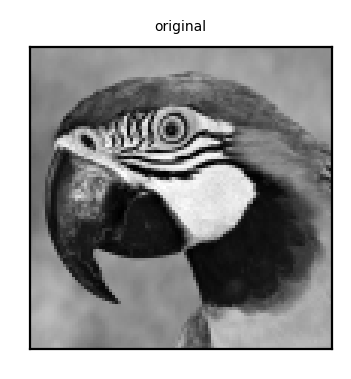

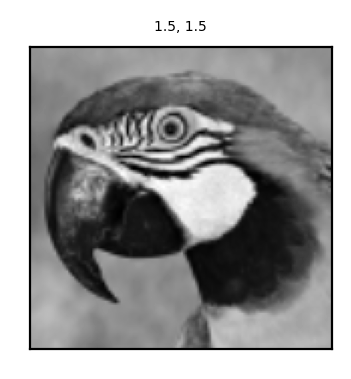

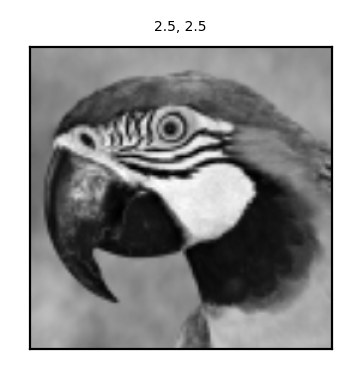

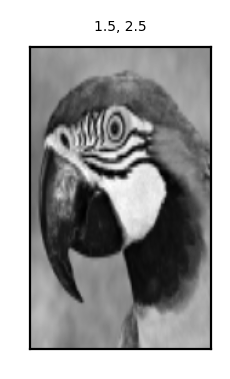

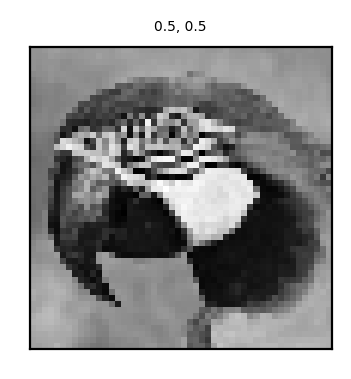

In [10]:
display_I(parrot, "original")
display_I(bilinear_interpolation(parrot,1.5,1.5), "1.5, 1.5")
display_I(bilinear_interpolation(parrot,2.5,2.5), "2.5, 2.5")
display_I(bilinear_interpolation(parrot,1.5,2.5), "1.5, 2.5")
display_I(bilinear_interpolation(parrot,0.5,0.5), "0.5, 0.5")

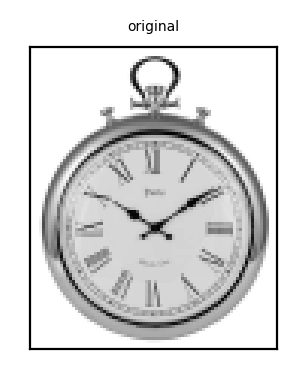

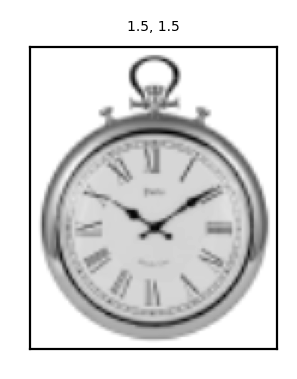

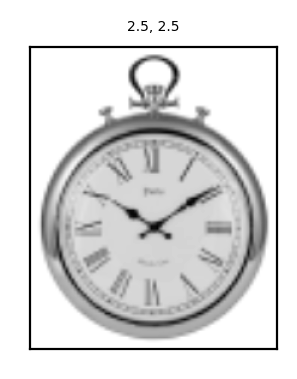

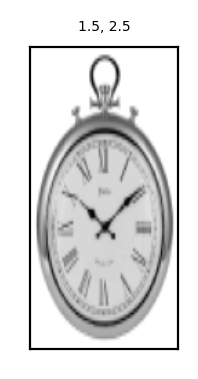

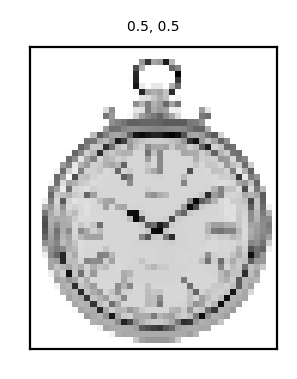

In [11]:
display_I(clock, "original")
display_I(bilinear_interpolation(clock,1.5,1.5), "1.5, 1.5")
display_I(bilinear_interpolation(clock,2.5,2.5), "2.5, 2.5")
display_I(bilinear_interpolation(clock,1.5,2.5), "1.5, 2.5")
display_I(bilinear_interpolation(clock,0.5,0.5), "0.5, 0.5")

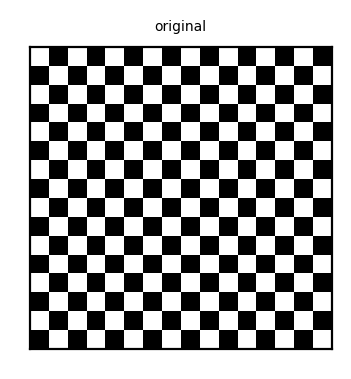

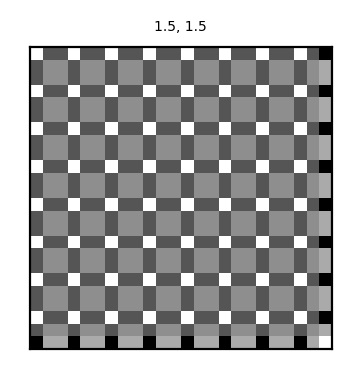

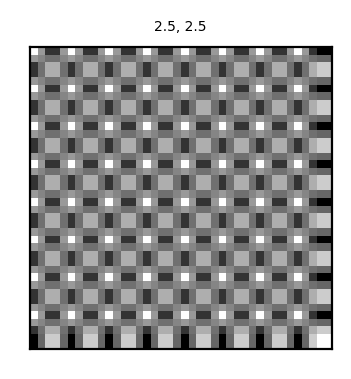

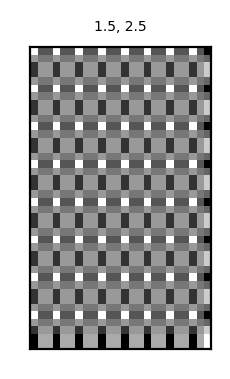

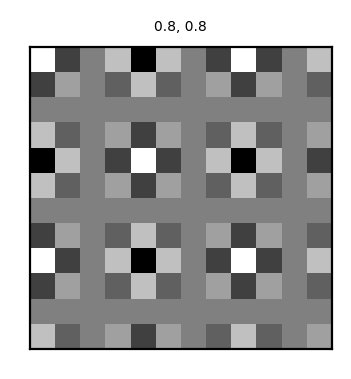

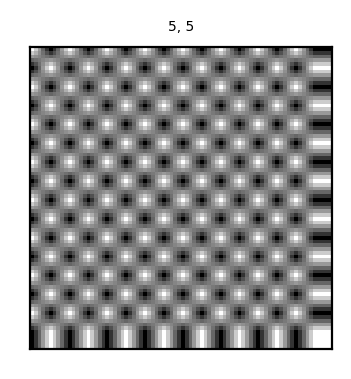

In [12]:
display_I(chessboard, "original")
display_I(bilinear_interpolation(chessboard,1.5,1.5), "1.5, 1.5")
display_I(bilinear_interpolation(chessboard,2.5,2.5), "2.5, 2.5")
display_I(bilinear_interpolation(chessboard,1.5,2.5), "1.5, 2.5")
display_I(bilinear_interpolation(chessboard,0.8,0.8), "0.8, 0.8")
display_I(bilinear_interpolation(chessboard,5,5), "5, 5")

## Intepolacja w OpenCV

W OpenCV dostępna jest funkcja `resize`, która służy do zmiany rozmiaru obrazka.
Składnia jest następująca `dst = cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])`, gdzie `dst` to obraz wynikowy, `src` obraz źródłowy, `dsize` rozmiar docelowy (ew. można podać współczynniki skalowania dla poszczególnych osi: `fx,fy`), `interpolation` metoda interpolacji.
Metod podstawowych dostępnych jest 5:
- najbliższego sąsiada - ` cv2.INTER_NEAREST`,
- dwuliniowa - ` cv2.INTER_LINEAR`,
- dwukubiczna - ` cv2.INTER_CUBIC`,
- *area* - ` cv2.INTER_AREA`,
- *lanczos4* - ` cv2.INTER_LANCZOS4`.

Przeprowadzimy następujący eksperyment: obraz (o większej niż dotąd rozdzielczości) przeskalujemy każdą z metod -- zwiększymy i zmniejszymy jego rozdzielczość. Dodamy też pomiar czasu realizacji obliczeń.

Obraz: TODO


Proszę stworzyć funkcję, która jako argumenty przyjmuje obraz oraz dwa współczynniki skalujące, a wewnątrz przeprowadzone zostaną interpolacje, pomiar czasu oraz wizualizacja (można wypisać czas w tytule rysunku).

Pomiar czasu:
```{python}
from timeit import default_timer as timer
start = timer()
# ...
end = timer()
print(end - start)
```

Wykonaj eksperyment dla kilku różnych skal, przeanalizuj czasy obliczeń.

In [13]:
from timeit import default_timer as timer

def openCV_interpolation(I, x_scale, y_scale):
    h, w = I.shape
    new_h = int(h * y_scale)
    new_w = int(w * x_scale) 
    method_names = ["cv2.INTER_NEAREST", "cv2.INTER_LINEAR", "cv2.INTER_CUBIC", "cv2.INTER_AREA", "cv2.INTER_LANCZOS4"]
    for method in [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4]:
        start = timer()
        dst = cv2.resize(I, (new_w, new_h), method)
        time = timer() - start
        
        plt.figure(figsize=(2,2), dpi=200)
        plt.imshow(I, cmap ="gray")
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.title(f"method: {method_names[method]}, scale: {y_scale, x_scale}, time: {round(time, 5)}", fontsize = 5)
        plt.show()

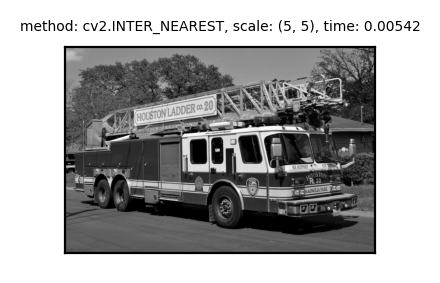

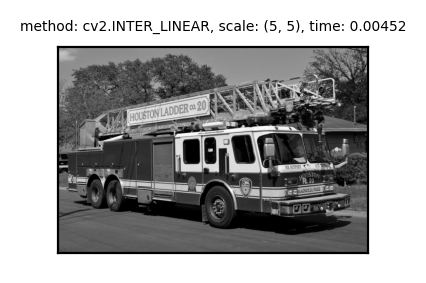

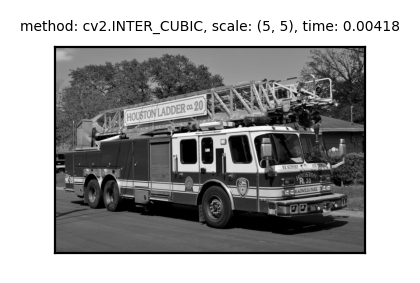

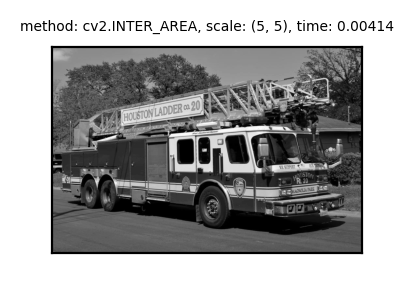

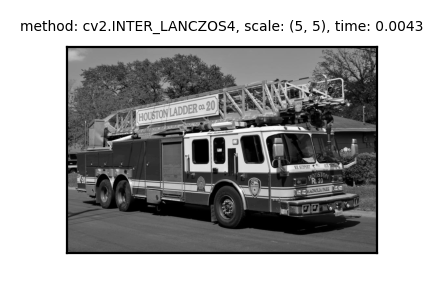

In [14]:
openCV_interpolation(firetruck, 5, 5)

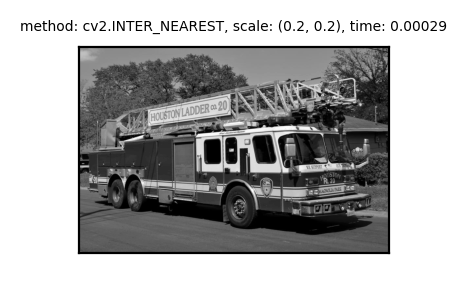

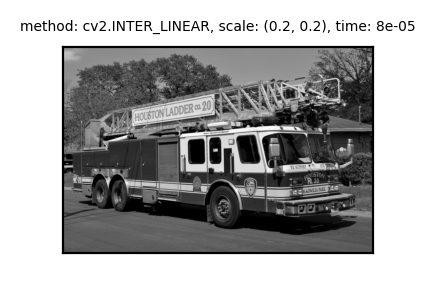

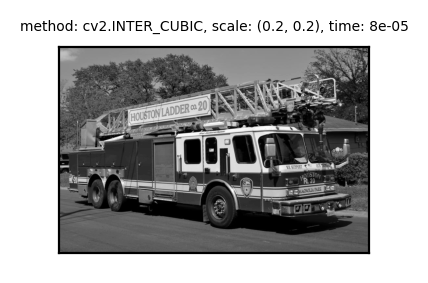

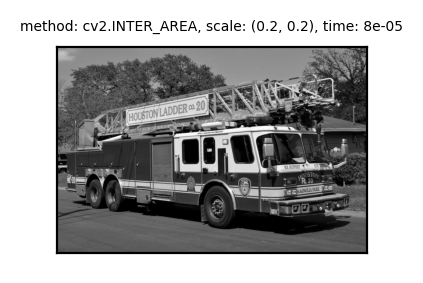

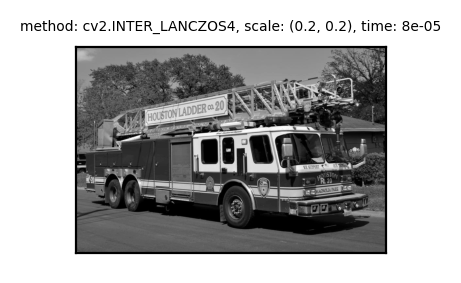

In [15]:
openCV_interpolation(firetruck, 0.2, 0.2)

## Rozdzielczość (dpi)

Omówioną wcześniej rozdzielczość przestrzenną (rozmiar) należy utożsamiać z rozmiarem macierzy w której zapisany jest obraz.
W tym ujęciu rozmiar pojedynczego piksela nie ma specjalnego znaczenia.
Problem pojawia się, kiedy obraz trzeba wyświetlić lub wydrukować.
Wtedy pojedynczy piksel staje się ,,obiektem fizycznym'' i musi mieć swój rozmiar (wysokość/szerokość/powierzchnię).

Parametr dpi (ang. *dots per inch*) określa liczbę kropek (pikseli), która mieści się na jednym calu (25,4 mm) długości/szerokości.
Dopiero kombinacja rozmiaru i rozdzielczości określa nam rzeczywisty rozmiar obrazu jaki uzyskamy na wydruku.

Dpi staje się istotne w przypadku drukowania, gdyż wyświetlanie na monitorze odbywa się zazwyczaj 1 piksel obrazka = 1 piksel na monitorze (w przypadku maksymalnej rozdzielczości wspieranej przez monitor), ew. następuje automatyczne skalowanie.

Wpływ rozdzielczości można zademonstrować w następujący sposób:
- wczytaj obraz *lena.bmp*.  Ma on rozmiar $512 \times 512$.
- wykorzystując funkcję `imresize` stwórz obrazy o rozmiarach $256 \times 256$, $128 \times 128$, $64 \times 64$ - metoda interpolacji jest w tym wypadku mniej istotna.
- wyświetl obrazy wymuszając zachowanie na ekranie wejściowej rozdzielczości $512 \times 512$. W przypadku biblioteki *matplotlib* ta funkcjonalność jest domyślna.

Proszę zaobserwować co dzieję się z obrazkiem.

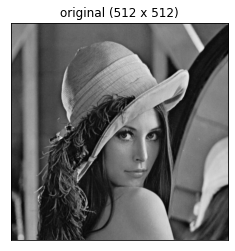

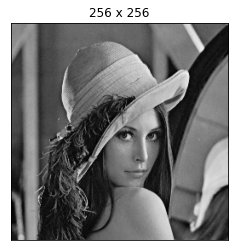

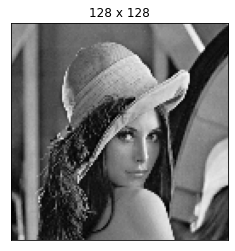

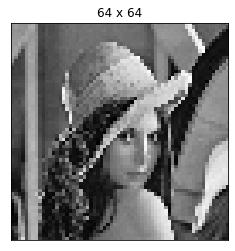

In [16]:
lena.shape
lena_256 = cv2.resize(lena, (256, 256), interpolation=cv2.INTER_NEAREST)
lena_128 = cv2.resize(lena, (128, 128), interpolation=cv2.INTER_NEAREST)
lena_64 = cv2.resize(lena, (64, 64), interpolation=cv2.INTER_NEAREST)

plt.imshow(lena, cmap="gray")
plt.title("original (512 x 512)")
plt.xticks([]), plt.yticks([]) 
plt.show()

plt.imshow(lena_256, cmap="gray")
plt.title("256 x 256")
plt.xticks([]), plt.yticks([]) 
plt.show()

plt.imshow(lena_128, cmap="gray")
plt.title("128 x 128")
plt.xticks([]), plt.yticks([]) 
plt.show()

plt.imshow(lena_64, cmap="gray")
plt.title("64 x 64")
plt.xticks([]), plt.yticks([]) 
plt.show()

## Liczba poziomów jasności

Dla obrazów w skali szarości pojedynczy piksel zwykle zapisuje się na 8 bitach, co daje 256 rozróżnialnych poziomów szarości.
Dla większości zastosowań wartość ta jest wystarczająca (choć są kamery o wyjścu 12 lub 16 bitów).
Jednak oko ludzkie nie potrafi rozróżnić wszystkich 256 poziomów jasności (jest za mało czułe).
Zazwyczaj człowiek rozróżnia 20-30 poziomów szarości (to ile i jakie dokładnie rozróżnia, zależy od konkretnego oświetlenia sceny i cech osobniczych).

W poniższych krokach zademonstrujemy omówione zjawisko:
- wczytaj (użyj) obrazu _lena_,
- wykorzystując znaną funkcję `normalize` zmień liczbę poziomów szarości z 0-255 na:
    * 0-31
    * 0-15
    * 0-7
    * 0-3
    * 0-1 (binaryzacja)
- rezultaty wyświetl na wspólnym rysunku.

Podpowiedzi:
- trzeba przygotować tablice na obrazki np, `I_31 = np.zeros(I.shape,'uint8')`,
- prawidłowe użycie funkcji normalize `cv2.normalize(I,I_31,0,31,cv2.NORM_MINMAX)`,
- przykładowe wyświetlanie `axsHist[0,1].imshow(I, 'gray', vmin=0, vmax=31)`.

Czy rezultaty eksperymentu pasują do teorii o rozpoznawaniu przez człowieka ograniczonego zakresu poziomów jasności?
Wizualne porównanie których obrazów o tym świadczy ?

(-0.5, 511.5, 511.5, -0.5)

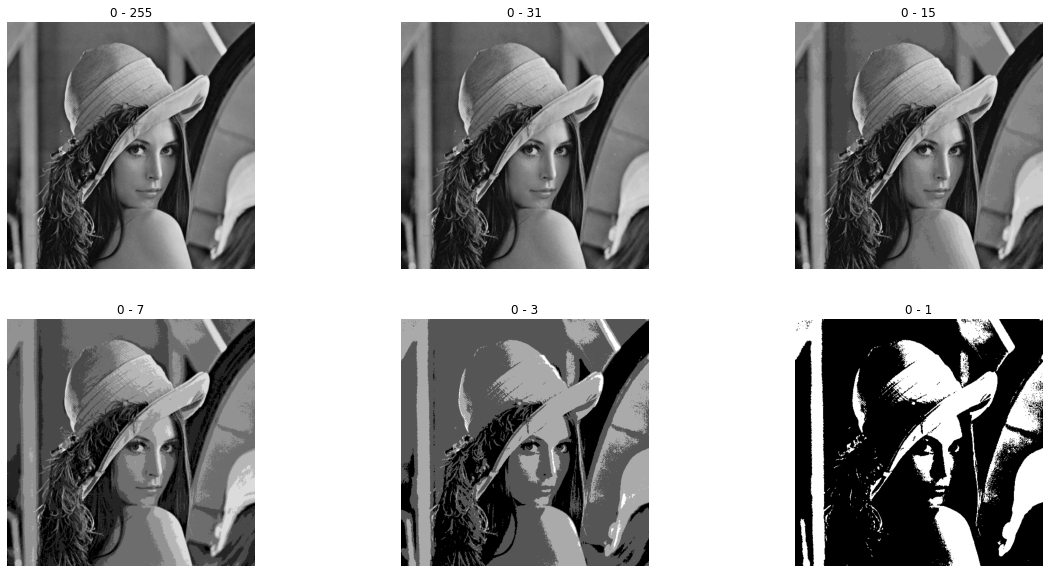

In [17]:
I = cv2.imread('lena.bmp')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

I1 = np.zeros(I.shape,'uint8')
cv2.normalize(I,I1,0,31, cv2.NORM_MINMAX)
I2 = np.zeros(I.shape,'uint8')
cv2.normalize(I,I2,0,15, cv2.NORM_MINMAX)
I3 = np.zeros(I.shape,'uint8')
cv2.normalize(I,I3,0,7, cv2.NORM_MINMAX)
I4 = np.zeros(I.shape,'uint8')
cv2.normalize(I,I4,0,3, cv2.NORM_MINMAX)
I5 = np.zeros(I.shape,'uint8')
cv2.normalize(I,I5,0,1, cv2.NORM_MINMAX)

f, ax = plt.subplots(2, 3)
f.set_size_inches(20, 10)
ax[0,0].set_title('0 - 255')
ax[0,0].imshow(I, 'gray')
ax[0,0].axis('off')

ax[0,1].set_title('0 - 31')
ax[0,1].imshow(I1, 'gray', vmin=0, vmax=31)
ax[0,1].axis('off')

ax[0,2].set_title('0 - 15')
ax[0,2].imshow(I2, 'gray', vmin=0, vmax=15)
ax[0,2].axis('off')

ax[1,0].set_title('0 - 7')
ax[1,0].imshow(I3, 'gray', vmin=0, vmax=7)
ax[1,0].axis('off')

ax[1,1].set_title('0 - 3')
ax[1,1].imshow(I4, 'gray', vmin=0, vmax=3)
ax[1,1].axis('off')

ax[1,2].set_title('0 - 1')
ax[1,2].imshow(I5, 'gray', vmin=0, vmax=1)
ax[1,2].axis('off')